In [547]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dotenv import load_dotenv
%matplotlib inline

load_dotenv()
project_root = os.getenv('PROJECT_ROOT')


In [548]:
# Load Raw Billing Data
csv_path = os.path.join(project_root, 'data', 'raw', 'industry', 'WSTS-Historical-Billings-Monthly-Report-Aug2024.csv')

df = pd.read_csv(csv_path, skiprows=3, header=0)

print(df.head(10))
print(df.columns)
print(df.shape)

     Unnamed: 0    January   February      March      April        May  \
0          1986        NaN        NaN        NaN        NaN        NaN   
1      Americas    555,850    633,465    756,220    689,470    718,336   
2        Europe    346,467    401,765    461,912    436,798    446,171   
3         Japan    638,547    750,366    840,215    838,082    870,515   
4  Asia Pacific    105,050    115,746    147,968    156,420    167,537   
5     Worldwide  1,645,914  1,901,342  2,206,315  2,120,770  2,202,559   
6          1987        NaN        NaN        NaN        NaN        NaN   
7      Americas    662,316    695,384    879,953    783,070    819,071   
8        Europe    446,216    460,982    551,635    483,195    522,679   
9         Japan    839,651    885,850    947,246    937,335    980,361   

        June       July     August  September    October   November  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1    797,014    707,784    697,506    803,3

In [549]:
# Melt the DataFrame
df_melted = df.melt(id_vars=df.columns[0], var_name='Month', value_name='Billing')

# Forward-fill the year information
df_melted['Year'] = df_melted[df.columns[0]].where(df_melted[df.columns[0]].str.isdigit()).ffill()

# Drop rows where 'Year' is NaN
df_melted = df_melted.dropna(subset=['Year'])

# Remove rows with 'Total Year', 'Q1', etc.
quarters_totals = ['Total Year', 'Q1', 'Q2', 'Q3', 'Q4']
df_melted = df_melted[~df_melted['Month'].isin(quarters_totals)]

# Clean 'Billing' column
df_melted['Billing'] = pd.to_numeric(df_melted['Billing'].astype(str).str.replace(',', ''), errors='coerce')

# Drop rows with NaN in 'Billing'
df_melted = df_melted.dropna(subset=['Billing'])

# Create 'Date' column
month_mapping = {
    'January': '01', 'February': '02', 'March': '03', 'April': '04',
    'May': '05', 'June': '06', 'July': '07', 'August': '08',
    'September': '09', 'October': '10', 'November': '11', 'December': '12',
}

df_melted['Month_Number'] = df_melted['Month'].map(month_mapping)
df_melted['Date'] = pd.to_datetime(df_melted['Year'].astype(int).astype(str) + '-' + df_melted['Month_Number'] + '-01')

# Select relevant columns
processed_df = df_melted[['Date', 'Billing', df.columns[0]]].rename(columns={df.columns[0]: 'Region'})

# Set 'Date' as index
processed_df.set_index('Date', inplace=True)

print(processed_df.head())
print(processed_df.info())


              Billing        Region
Date                               
1986-01-01   555850.0      Americas
1986-01-01   346467.0        Europe
1986-01-01   638547.0         Japan
1986-01-01   105050.0  Asia Pacific
1986-01-01  1645914.0     Worldwide
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2320 entries, 1986-01-01 to 2023-12-01
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Billing  2320 non-null   float64
 1   Region   2320 non-null   object 
dtypes: float64(1), object(1)
memory usage: 54.4+ KB
None


In [550]:
# Define the path to save the processed data
processed_data_dir = os.path.join(project_root, 'data', 'processed')
os.makedirs(processed_data_dir, exist_ok=True)

# Save processed data
processed_df.to_csv(os.path.join(processed_data_dir, 'global_billings_processed.csv'))

# Create pivot table and save
pivot_df = processed_df.pivot_table(values='Billing', index=processed_df.index, columns='Region')
pivot_df.to_csv(os.path.join(processed_data_dir, 'global_billings_pivot.csv'))


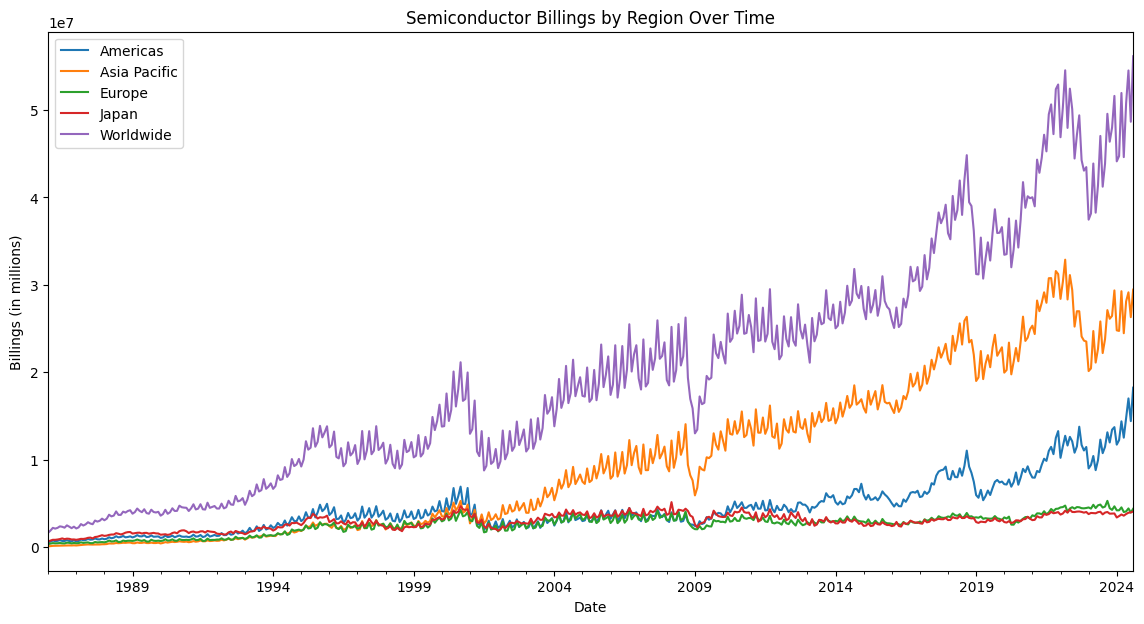

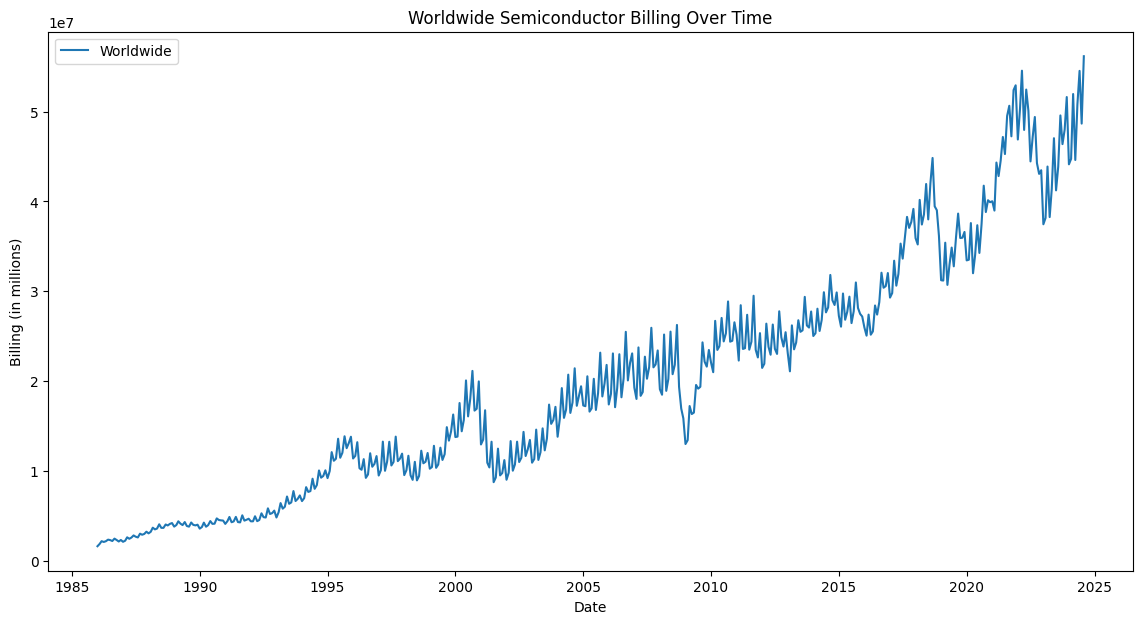

In [551]:
# Data Visualization

def plot_time_series(df, y_column, title, ylabel):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df[y_column], label=y_column)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Plot billing by region
pivot_df.plot(figsize=(14, 7))
plt.title('Semiconductor Billings by Region Over Time')
plt.xlabel('Date')
plt.ylabel('Billings (in millions)')
plt.legend()
plt.show()

# Plot worldwide billing
worldwide_df = pivot_df[['Worldwide']]
plot_time_series(worldwide_df, 'Worldwide', 'Worldwide Semiconductor Billing Over Time', 'Billing (in millions)')

In [552]:
# Load macroeconomic data
macro_df = pd.read_csv(
    os.path.join(project_root, 'data', 'processed', 'macro_data_processed.csv'),
    parse_dates=['date'],
    index_col='date'
)

# Adjust macro_df dates from last day to first day of the same month
macro_df.index = macro_df.index.to_period('M').to_timestamp()

# Ensure indices are datetime and normalized
macro_df.index = pd.to_datetime(macro_df.index).normalize()
worldwide_df.index = pd.to_datetime(worldwide_df.index).normalize()

# Determine overlapping date range
start_date = max(worldwide_df.index.min(), macro_df.index.min())
end_date = min(worldwide_df.index.max(), macro_df.index.max())

# Truncate DataFrames to overlapping date range
worldwide_df = worldwide_df.loc[start_date:end_date]
macro_df = macro_df.loc[start_date:end_date]

# Merge the DataFrames
combined_df = worldwide_df.join(macro_df, how='inner')

# Check for missing values
print("Missing values in combined_df:\n", combined_df.isnull().sum())

combined_df = combined_df.dropna()

print("combined_df is empty:", combined_df.empty)
print("combined_df head:")
print(combined_df.head())

Missing values in combined_df:
 Worldwide    0
GDP          0
CPIAUCSL     0
UNRATE       0
FEDFUNDS     0
dtype: int64
combined_df is empty: False
combined_df head:
            Worldwide          GDP  CPIAUCSL  UNRATE  FEDFUNDS
Date                                                          
1986-01-01  1645914.0  4507.894000     109.9     6.7      8.14
1986-02-01  1901342.0  4520.792067     109.7     7.2      7.86
1986-03-01  2206315.0  4532.441933     109.1     7.2      7.48
1986-04-01  2120770.0  4545.340000     108.7     7.1      6.99
1986-05-01  2202559.0  4565.888022     109.0     7.2      6.85


In [553]:
# Cell 8: Descriptive Statistics and Visualization

# Get descriptive statistics
print(combined_df.describe())



          Worldwide           GDP    CPIAUCSL      UNRATE    FEDFUNDS
count  4.640000e+02    464.000000  464.000000  464.000000  464.000000
mean   1.992616e+07  13513.910894  196.741054    5.755172    3.312888
std    1.336130e+07   6502.272481   52.970578    1.674680    2.694498
min    1.645914e+06   4507.894000  108.700000    3.400000    0.050000
25%    9.535604e+06   7735.877818  153.050000    4.500000    0.387500
50%    1.760630e+07  12958.917429  193.650000    5.400000    3.055000
75%    2.773552e+07  18025.254951  237.058500    6.625000    5.405000
max    5.615892e+07  29349.924000  314.121000   14.800000    9.850000


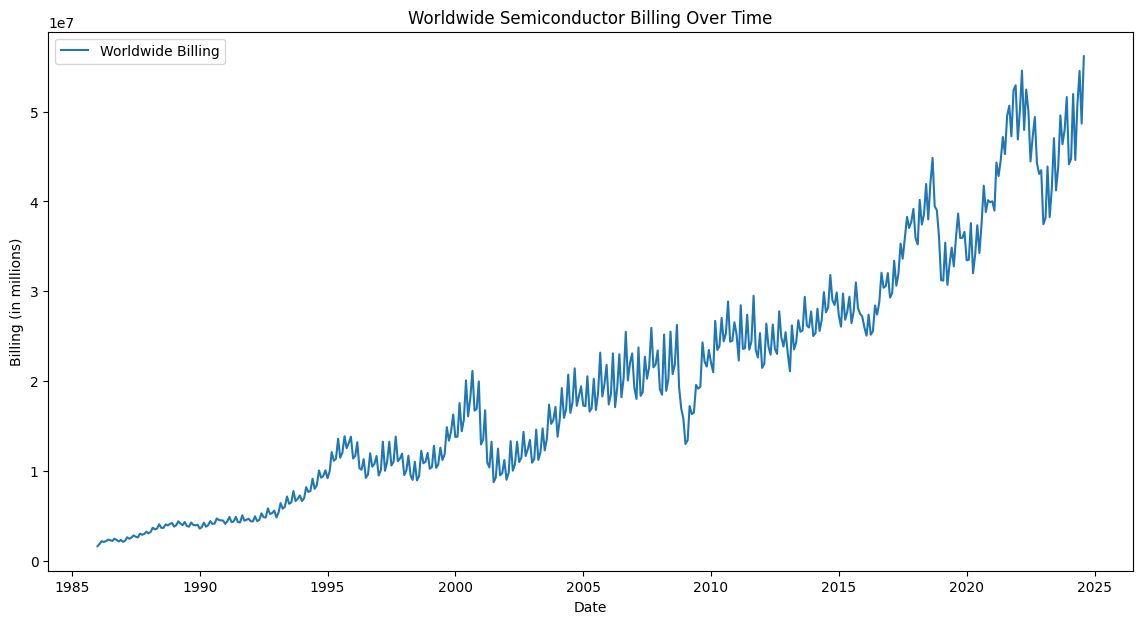

In [554]:
plt.figure(figsize=(14, 7))
plt.plot(combined_df.index, combined_df['Worldwide'], label='Worldwide Billing')
plt.title('Worldwide Semiconductor Billing Over Time')
plt.xlabel('Date')
plt.ylabel('Billing (in millions)')
plt.legend()
plt.show()


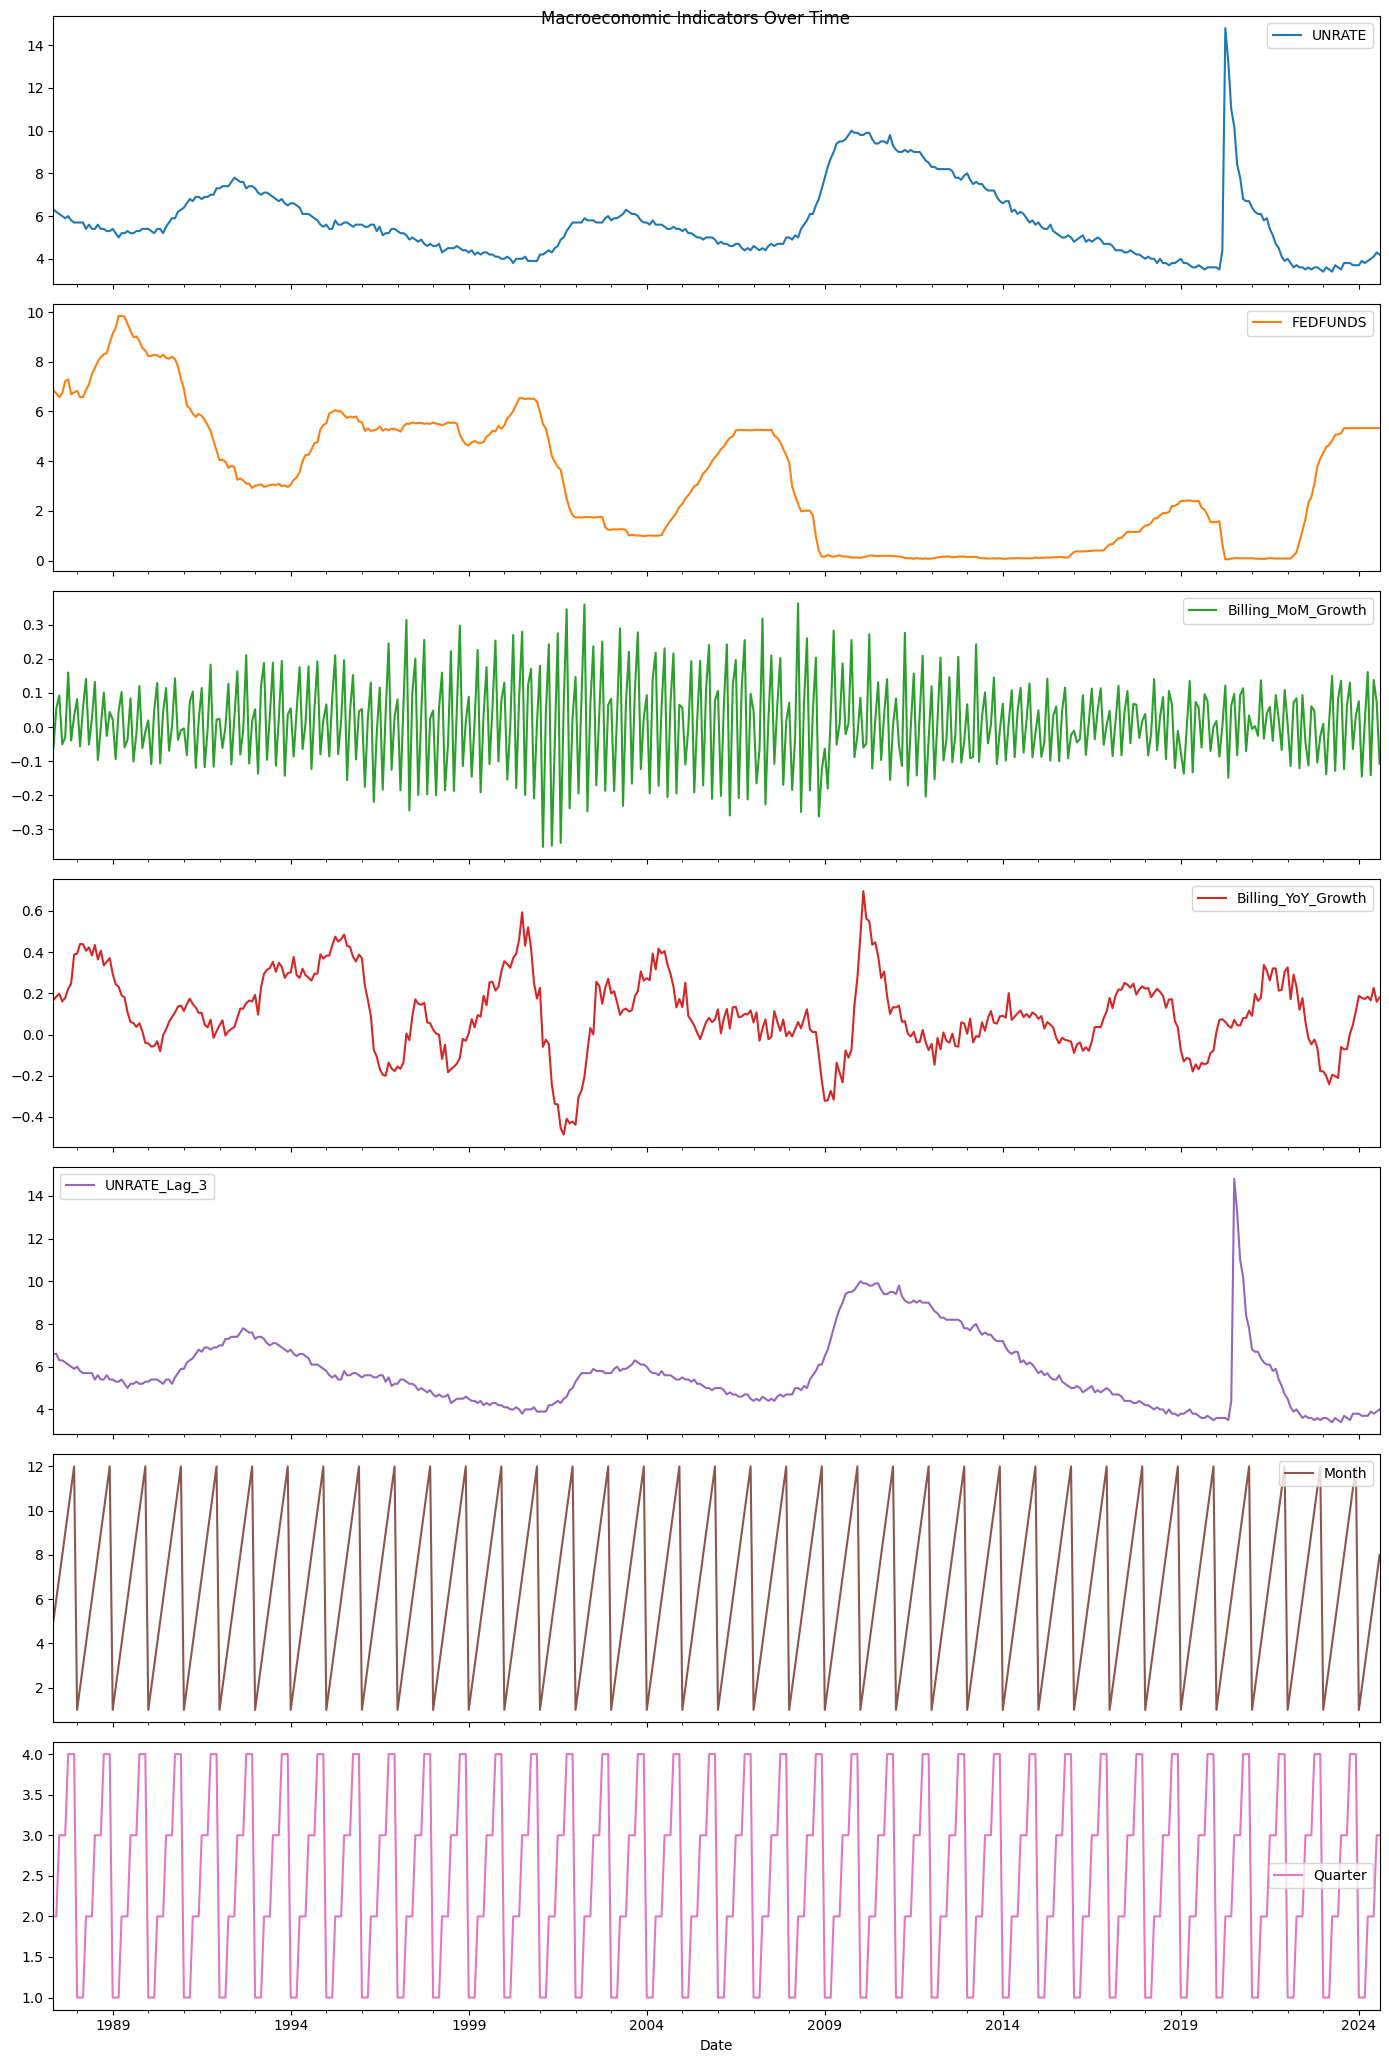

In [580]:
# Visualize Macroeconomic Indicators Over Time
macro_vars = combined_df.columns.drop('Worldwide')
combined_df[macro_vars].plot(subplots=True, figsize=(14, len(macro_vars) * 3), sharex=True)
plt.suptitle('Macroeconomic Indicators Over Time')
plt.tight_layout()
plt.show()


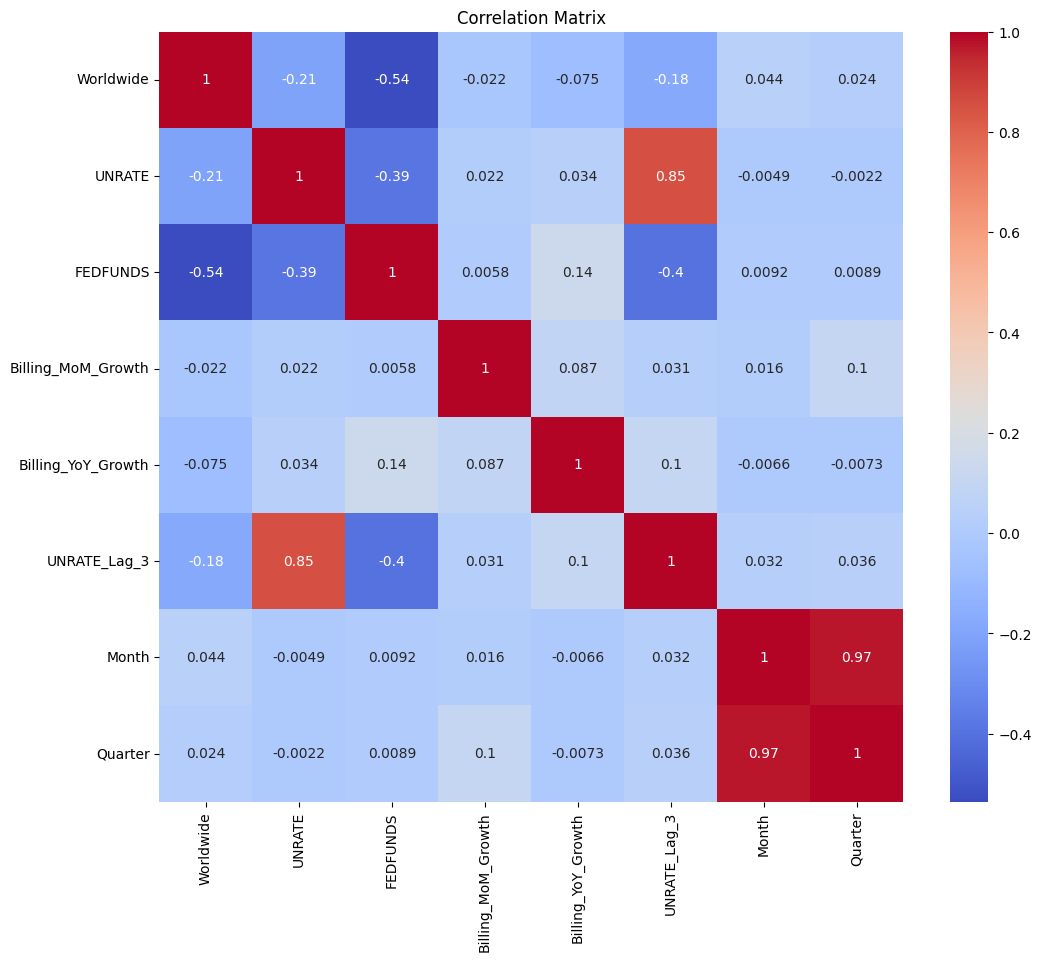

In [581]:
# Compute and plot the correlation matrix
corr_matrix = combined_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# Create lag features for 'Worldwide' billing (up to 12 months)
for lag in range(1, 13):
    combined_df[f'Billing_Lag_{lag}'] = combined_df['Worldwide'].shift(lag)


In [ ]:
# Calculate growth rates using past data only
combined_df['Billing_MoM_Growth'] = combined_df['Worldwide'].pct_change().shift(1)
combined_df['Billing_YoY_Growth'] = combined_df['Worldwide'].pct_change(12).shift(1)


In [ ]:
# Calculate moving averages using past data
combined_df['Billing_MA_3'] = combined_df['Worldwide'].rolling(window=3, min_periods=1).mean().shift(1)
combined_df['Billing_MA_12'] = combined_df['Worldwide'].rolling(window=12, min_periods=1).mean().shift(1)


In [ ]:
# Create lag features for macroeconomic variables
for var in ['GDP', 'CPIAUCSL', 'UNRATE', 'FEDFUNDS']:
    combined_df[f'{var}_Lag_1'] = combined_df[var].shift(1)
    combined_df[f'{var}_Lag_3'] = combined_df[var].shift(3)


In [ ]:
# Add month and quarter as features to capture seasonality
combined_df['Month'] = combined_df.index.month
combined_df['Quarter'] = combined_df.index.quarter


In [582]:
# Drop rows with NaN values resulting from shifting
combined_df = combined_df.dropna()


In [583]:
# Identify and drop highly correlated features
import numpy as np

# Compute the absolute correlation matrix
corr_matrix = combined_df.corr().abs()

# Select upper triangle of correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
high_corr_vars = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

# Drop highly correlated features
combined_df = combined_df.drop(columns=high_corr_vars)


In [584]:
# Define the target variable and features
y = combined_df['Worldwide']
X = combined_df.drop(columns=['Worldwide'])


In [585]:
# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(combined_df) * 0.8)
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]


In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [586]:
from sklearn.linear_model import LinearRegression

# Initialize and train the model using scaled data
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test_scaled)


In [587]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f'Linear Regression MSE: {mse_lr:.2f}')
print(f'Linear Regression R^2 Score: {r2_lr:.2f}')


Linear Regression MSE: 500863120711597.94
Linear Regression R^2 Score: -10.90


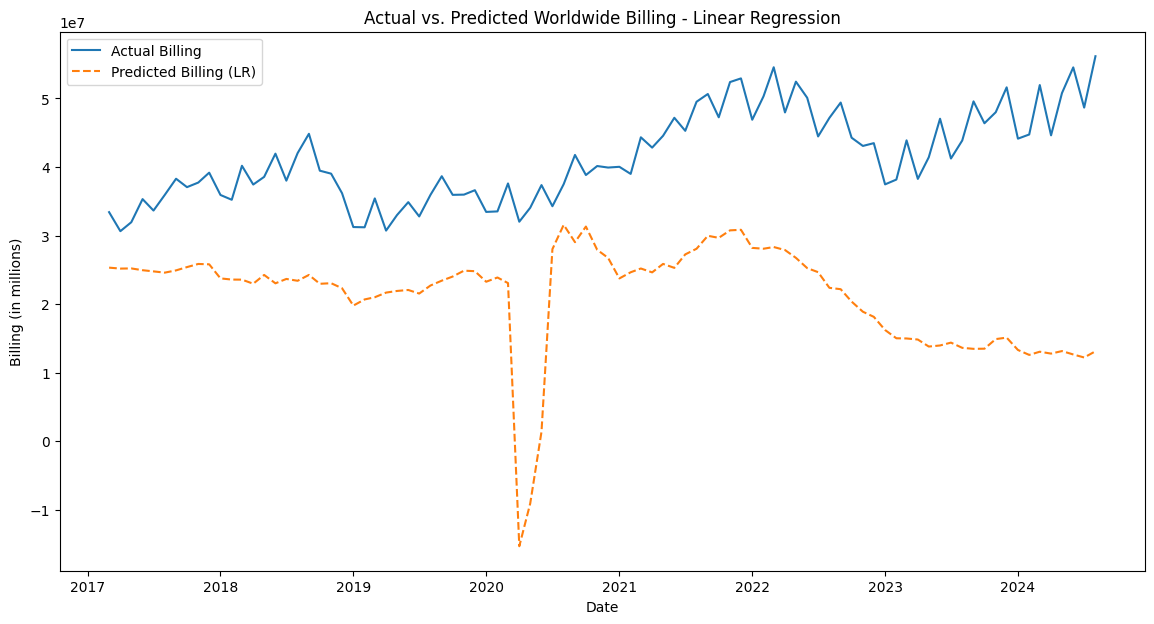

In [588]:
# Plot actual vs. predicted billing
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Billing')
plt.plot(y_test.index, y_pred_lr, label='Predicted Billing (LR)', linestyle='--')
plt.title('Actual vs. Predicted Worldwide Billing - Linear Regression')
plt.xlabel('Date')
plt.ylabel('Billing (in millions)')
plt.legend()
plt.show()


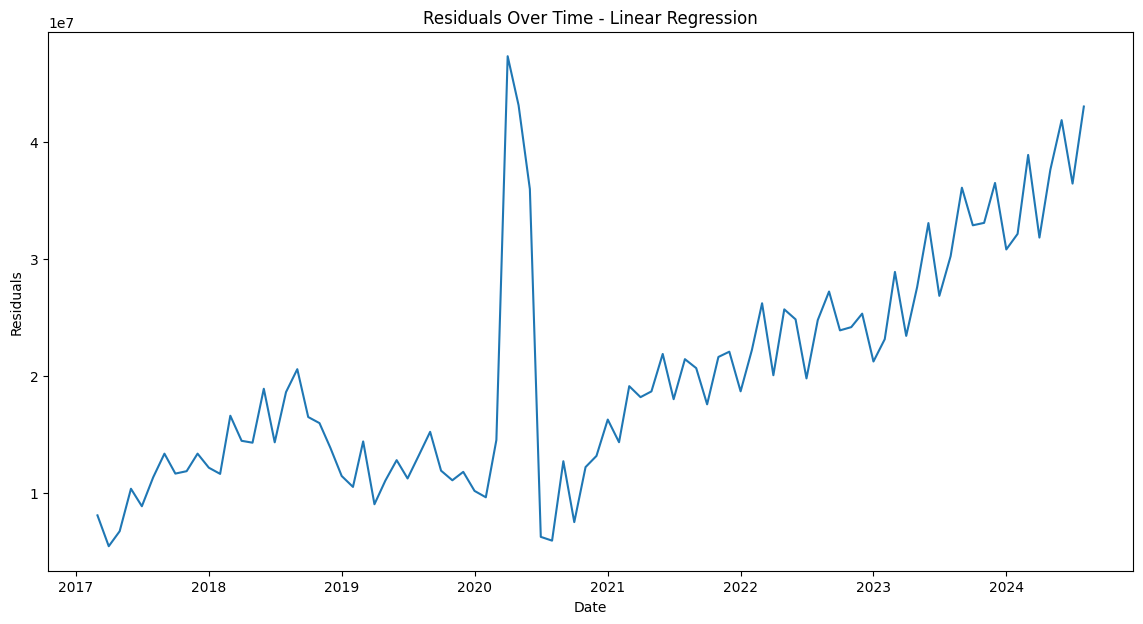

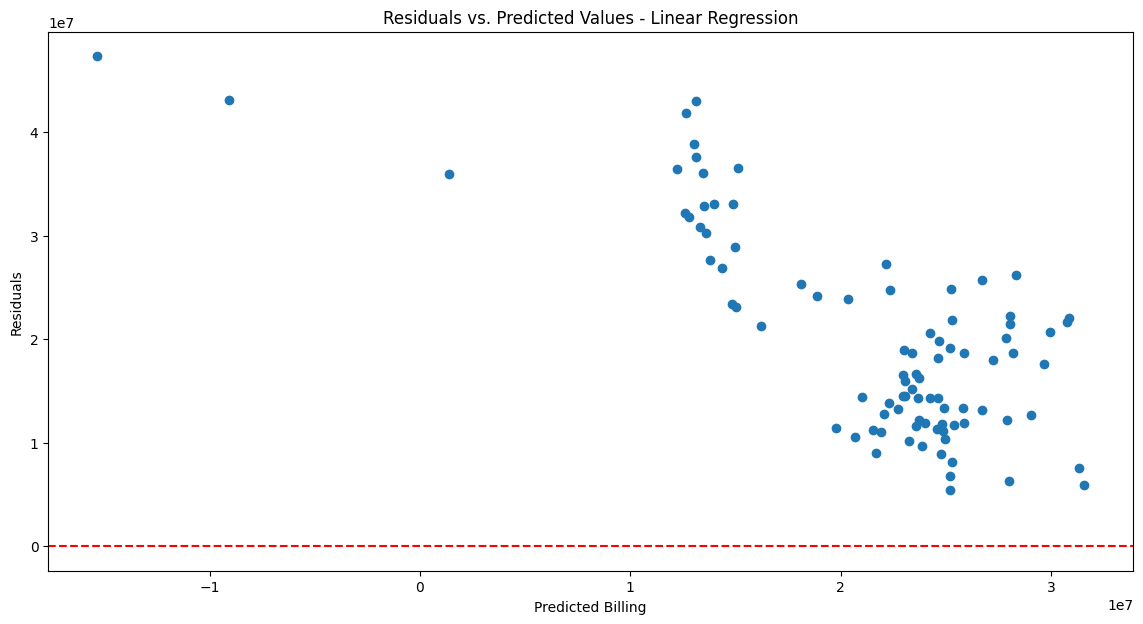

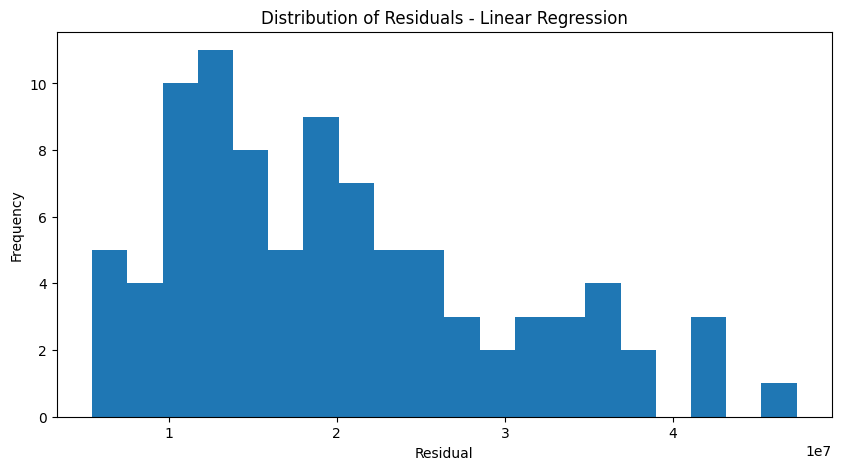

In [589]:
# Calculate residuals
residuals_lr = y_test - y_pred_lr

# Plot residuals over time
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, residuals_lr)
plt.title('Residuals Over Time - Linear Regression')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# Plot residuals vs. predicted values
plt.figure(figsize=(14, 7))
plt.scatter(y_pred_lr, residuals_lr)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values - Linear Regression')
plt.xlabel('Predicted Billing')
plt.ylabel('Residuals')
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 5))
plt.hist(residuals_lr, bins=20)
plt.title('Distribution of Residuals - Linear Regression')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()


In [590]:
# Create a DataFrame of features and coefficients
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print(coefficients)


              Feature   Coefficient
4        UNRATE_Lag_3  3.321664e+06
5               Month  5.933068e+05
3  Billing_YoY_Growth  2.877004e+05
2  Billing_MoM_Growth -7.351269e+04
0              UNRATE -5.715720e+06
1            FEDFUNDS -7.463035e+06


In [591]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)
print(f'Random Forest MSE: {rf_mse:.2f}, R^2 Score: {rf_r2:.2f}')


Random Forest MSE: 595570817427169.38, R^2 Score: -13.15


In [592]:
import xgboost as xgb

# Initialize and train the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_r2 = r2_score(y_test, y_pred_xgb)
print(f'XGBoost MSE: {xgb_mse:.2f}, R^2 Score: {xgb_r2:.2f}')


XGBoost MSE: 508969316252763.81, R^2 Score: -11.09


In [593]:
from sklearn.neural_network import MLPRegressor

# Initialize the neural network with increased max_iter and early stopping
nn_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    max_iter=500,
    early_stopping=True,
    random_state=42
)

# Train the model
nn_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_nn = nn_model.predict(X_test_scaled)

# Evaluate the model
nn_mse = mean_squared_error(y_test, y_pred_nn)
nn_r2 = r2_score(y_test, y_pred_nn)
print(f'Neural Network MSE: {nn_mse:.2f}, R^2 Score: {nn_r2:.2f}')


Neural Network MSE: 1756993802845481.00, R^2 Score: -40.74


In [594]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

# Train the model with best parameters
best_rf_model = grid_search.best_estimator_

# Make predictions
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluate the model
best_rf_mse = mean_squared_error(y_test, y_pred_best_rf)
best_rf_r2 = r2_score(y_test, y_pred_best_rf)
print(f'Best Random Forest MSE: {best_rf_mse:.2f}, R^2 Score: {best_rf_r2:.2f}')


Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest MSE: 595570817427169.38, R^2 Score: -13.15


In [596]:
from prophet import Prophet

# Prepare data for Prophet
prophet_df = combined_df.reset_index()[['Date', 'Worldwide']].rename(columns={'Date': 'ds', 'Worldwide': 'y'})

# Split data
prophet_train = prophet_df.iloc[:train_size]
prophet_test = prophet_df.iloc[train_size:]

# Initialize and fit the model
prophet_model = Prophet()
prophet_model.fit(prophet_train)

# Make future dataframe
future = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='ME')

# Forecast
forecast = prophet_model.predict(future)

# Extract predictions for the test set
y_pred_prophet = forecast['yhat'].iloc[train_size:]

# Evaluate the model
prophet_mse = mean_squared_error(y_test, y_pred_prophet)
prophet_r2 = r2_score(y_test, y_pred_prophet)
print(f'Prophet MSE: {prophet_mse:.2f}, R^2 Score: {prophet_r2:.2f}')


16:56:26 - cmdstanpy - INFO - Chain [1] start processing
16:56:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet MSE: 87421815923457.25, R^2 Score: -1.08


In [597]:
# Create a DataFrame to compare model performance
model_performance = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'Neural Network', 'Prophet'],
    'MSE': [mse_lr, rf_mse, xgb_mse, nn_mse, prophet_mse],
    'R^2 Score': [r2_lr, rf_r2, xgb_r2, nn_r2, prophet_r2]
})

print(model_performance)


               Model           MSE  R^2 Score
0  Linear Regression  5.008631e+14 -10.898036
1      Random Forest  5.955708e+14 -13.147824
2            XGBoost  5.089693e+14 -11.090599
3     Neural Network  1.756994e+15 -40.737503
4            Prophet  8.742182e+13  -1.076711
